<a href="https://colab.research.google.com/github/ThalesGomesJr/Plasmodium-Classifier/blob/master/ClassificadorPlasmodium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Rede Neural Convolucional para Classificar Plasmodium

---



### Etapa 1: Adicionando Bibliotecas

---



In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [ ]:
torch.manual_seed(123)

### Etapa 2: Contrução do Modelo

---



In [ ]:
#output = (input - filter + 1) / stride
classificador = nn.Sequential(nn.Conv2d(in_channels = 3, 
                                        out_channels = 32,
                                        kernel_size = 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features = 32),
                              #(64 - 3 + 1) / 1 = 62x62
                              nn.MaxPool2d(kernel_size = 2),
                              #31x31
                              nn.Conv2d(32, 32, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(32),
                              #(31 - 3 + 1) / 1 = 29x29
                              nn.MaxPool2d(2),
                              #14x14
                              nn.Flatten(),
                              #6272 -> 128 -> 128 -> 1
                              nn.Linear(in_features = 14*14*32, out_features = 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 1),
                              nn.Sigmoid())

In [ ]:
criterion = nn.BCELoss()
optmizer = optim.Adam(classificador.parameters())

### Etapa 3: Base de dados

---

In [ ]:
path = '/content/drive/My Drive/PIBITI/Dataset Plasmodium/plasmodium_images.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_dir_train = '/content/plasmodium_images/dataset/train_set'
data_dir_test = '/content/plasmodium_images/dataset/test_set'

In [ ]:
#Transforma as imagens para que após o treinamento a rede neural também consiga 
#classificar imagens com qualidade ruim, ou distorcidas.
transform_train = transforms.Compose(
    [
     #Dimensiona todas as imagem para ter o mesmo tamanho. 
     transforms.Resize([64, 64]),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(degrees = 7, translate = (0, 0.07), shear = 0.2, scale = (1, 1.2)),
     #transforma para o formto tensor
     transforms.ToTensor()
    ]
)

In [ ]:
transform_test = transforms.Compose(
    [
     #Dimensiona todas as imagem para ter o mesmo tamanho.
     transforms.Resize([64, 64]),
     #transforma para o formto tensor
     transforms.ToTensor()
    ]
)

In [ ]:
#Cria o dataset para treinamento
train_dataset = datasets.ImageFolder(data_dir_train, transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [ ]:
#Cria o dataset para teste
test_dataset = datasets.ImageFolder(data_dir_test, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

### Etapa 4: Treinamento do modelo


---

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [ ]:
#Função de treinamento da rede
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optmizer.zero_grad()        
        outputs = classificador(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optmizer.step()

        running_loss += loss.item()

        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
                   
        #Imprimindo os dados referentes a esse loop
        print('\r ÉPOCA {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, accuracy), end = '\r')
        
    #Imprimindo os dados referentes a essa época
    print('\r ÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), running_accuracy/len(loader)))


In [ ]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
 ÉPOCA   1 FINALIZADA: perda 0.33793 - precisão 0.86425
Validando...
 ÉPOCA   1 FINALIZADA: perda 0.17258 - precisão 0.94601
Treinando...
 ÉPOCA   2 FINALIZADA: perda 0.17387 - precisão 0.94185
Validando...
 ÉPOCA   2 FINALIZADA: perda 0.14232 - precisão 0.95240
Treinando...
 ÉPOCA   3 FINALIZADA: perda 0.15724 - precisão 0.94833
Validando...
 ÉPOCA   3 FINALIZADA: perda 0.12116 - precisão 0.96134
Treinando...
 ÉPOCA   4 FINALIZADA: perda 0.14831 - precisão 0.95196
Validando...
 ÉPOCA   4 FINALIZADA: perda 0.11252 - precisão 0.95978
Treinando...
 ÉPOCA   5 FINALIZADA: perda 0.15049 - precisão 0.95196
Validando...
 ÉPOCA   5 FINALIZADA: perda 0.11039 - precisão 0.96455
Treinando...
 ÉPOCA   6 FINALIZADA: perda 0.14686 - precisão 0.95075
Validando...
 ÉPOCA   6 FINALIZADA: perda 0.08738 - precisão 0.97205
Treinando...
 ÉPOCA   7 FINALIZADA: perda 0.14198 - precisão 0.95296
Validando...
 ÉPOCA   7 FINALIZADA: perda 0.08887 - precisão 0.97106
Treinando...
 ÉPOCA   8 FINALIZADA

### Etapa 5: Avaliação do Modelo

---

In [ ]:
#Função de classificação da imagem inserida
def classificar_imagem(fname):
  from PIL import Image
  imagem_teste = Image.open(data_dir_test + '/' + fname)
  plt.imshow(imagem_teste)
  plt.show()
  
  imagem_teste = imagem_teste.resize((64, 64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)
  #Se a previsão de Uninfected for maior que 50%
  if output > 0.5:
    output = 0
  #Caso a previsão de Uninfected for menor que 50% a rede neural classifica como Parasitized 
  else:
    output = 1
  print('Previsão: ', output)
  #Usar quando inserir um array de imagens
  if output == 0: 
    print('|Uninfected|') 
  else: 
    print('|Parasitized|')
  print('___________________________')
  
  #Usar quando inserir uma imagem por vez
  #idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
  #return idx_to_class[output]

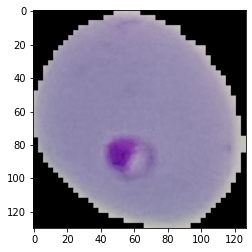

Previsão:  1
|Parasitized|
___________________________


In [ ]:
import os
import random

imagens = os.listdir(data_dir_test + '/Parasitized')

img_selecionada = random.choice(imagens)
classificar_imagem('/Parasitized/' + img_selecionada)

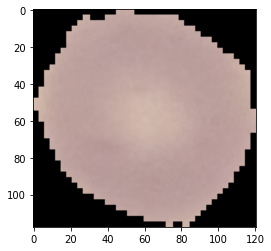

Previsão:  0
|Uninfected|
___________________________


In [ ]:
import os
import random

imagens = os.listdir(data_dir_test + '/Uninfected')

img_selecionada = random.choice(imagens)
classificar_imagem('/Uninfected/' + img_selecionada)